## Compare filters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gcm_filters import filter
from gcm_filters.kernels import GridType
from gaussian_filter import gaussian_filter

Script parameters

In [2]:
filter_scale=4
cmap='Spectral'
vmax=0.2
vmin=-vmax

plt_args = dict(vmin=vmin, vmax=vmax, cmap=cmap)

data_location = '/media/arthur/DATA/Data sets/CM2.6'
grid_filename = 'grid_dataforeli'
uv_filename = 'uv_dataforeli'

Read the data from North Atlantic


In [3]:
from read_data import read_data

grid_data, data = read_data(data_location, uv_filename,grid_filename)
grid_data = grid_data.compute().reset_coords()

data = data['usurf'].isel(time=0).sel(xu_ocean=slice(-50, -30),
                                      yu_ocean=slice(20, 40)).compute()

print(data)

<xarray.DataArray 'usurf' (yu_ocean: 233, xu_ocean: 200)>
array([[ 0.0052095 ,  0.0121594 ,  0.03561332, ..., -0.11311119,
        -0.11542519, -0.12460815],
       [ 0.03894901,  0.06944064,  0.09944243, ..., -0.13351831,
        -0.13717829, -0.14902033],
       [ 0.11084751,  0.12638816,  0.12309232, ..., -0.14770103,
        -0.15378124, -0.16486923],
       ...,
       [ 0.32959267,  0.33172452,  0.3267957 , ...,  0.04047012,
         0.07512608,  0.1155312 ],
       [ 0.40948772,  0.43703133,  0.4470314 , ...,  0.0787665 ,
         0.11769381,  0.15516993],
       [ 0.5507932 ,  0.58537173,  0.60209614, ...,  0.1143743 ,
         0.14385784,  0.15787417]], dtype=float32)
Coordinates:
    time      object 0181-01-01 12:00:00
  * xu_ocean  (xu_ocean) float64 -49.9 -49.8 -49.7 -49.6 ... -30.2 -30.1 -30.0
  * yu_ocean  (yu_ocean) float64 20.08 20.17 20.26 20.36 ... 39.84 39.91 39.99
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_c geolat_c
    time_avg_info:  a

Question: how do we address continents?

In [4]:
grid_data_save = grid_data
grid_data = grid_data[['dxt', 'dyt', 'dxu', 'dyu', 'area_u']]

Problem: we need the grid vars to be on the same grid as the field to
be filtered. Here I've interpolated, but I think this is not right,
we can probably just redefine the coords of dxt and dyt to be those of the
velocities, we'll just have to be careful.

In [5]:
# Dont't do interp
grid_data['dxt'] = grid_data['dxt'].interp(dict(xt_ocean=data.xu_ocean,
                                  yt_ocean=data.yu_ocean), method='nearest')
grid_data['dyt'] = grid_data['dyt'].interp(dict(xt_ocean=data.xu_ocean,
                                  yt_ocean=data.yu_ocean), method='nearest')
grid_data = grid_data.sel(xu_ocean=slice(-50, -30), yu_ocean=slice(20, 40))
del grid_data['xt_ocean']
del grid_data['yt_ocean']
print(grid_data)

<xarray.Dataset>
Dimensions:   (xu_ocean: 200, yu_ocean: 233)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -49.9 -49.8 -49.7 -49.6 ... -30.2 -30.1 -30.0
  * yu_ocean  (yu_ocean) float64 20.08 20.17 20.26 20.36 ... 39.84 39.91 39.99
    time      object 0181-01-01 12:00:00
Data variables:
    dxt       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.524e+03
    dyt       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.524e+03
    dxu       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    dyu       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    area_u    (yu_ocean, xu_ocean) float32 1.091e+08 1.091e+08 ... 7.258e+07
Attributes:
    NCO:      4.0.3


Create the filter and print its specs

In [6]:
dx_min = np.min(grid_data['dxt'].values)
mom5_filter = filter.Filter(1e5, dx_min=dx_min,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars=grid_data,
                                 grid_type=GridType.MOM5)
print(mom5_filter.filter_spec)


FilterSpec(n_lap_steps=20, s_l=array([1.61872545e-08, 2.41626525e-08, 3.57919245e-08, 4.91968807e-08,
       6.42201985e-08, 8.05903983e-08, 9.80088176e-08, 1.16154236e-07,
       1.34689095e-07, 1.53266144e-07, 1.71535360e-07, 1.89150943e-07,
       2.05778245e-07, 2.21100476e-07, 2.34825039e-07, 2.46689382e-07,
       2.56466244e-07, 2.63968257e-07, 2.69052219e-07, 2.71677071e-07]), n_bih_steps=1, s_b=array([8.19778328e-09-6.61894573e-09j]))


Carry out filtering operation

In [7]:
print(grid_data)

<xarray.Dataset>
Dimensions:   (xu_ocean: 200, yu_ocean: 233)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -49.9 -49.8 -49.7 -49.6 ... -30.2 -30.1 -30.0
  * yu_ocean  (yu_ocean) float64 20.08 20.17 20.26 20.36 ... 39.84 39.91 39.99
    time      object 0181-01-01 12:00:00
Data variables:
    dxt       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.524e+03
    dyt       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.524e+03
    dxu       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    dyu       (yu_ocean, xu_ocean) float64 1.044e+04 1.044e+04 ... 8.519e+03
    area_u    (yu_ocean, xu_ocean) float32 1.091e+08 1.091e+08 ... 7.258e+07
Attributes:
    NCO:      4.0.3


In [8]:
filtered_data = mom5_filter.apply(data, dims=['yu_ocean', 'xu_ocean'])

Plot the result

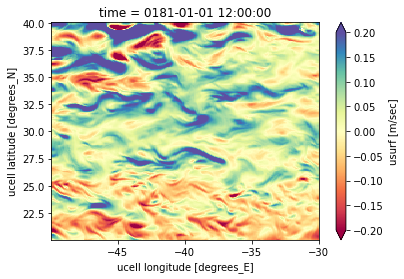

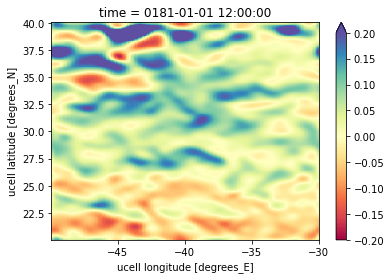

In [9]:
plt.figure()
data.plot(**plt_args)
plt.figure()
filtered_data.plot(**plt_args)
plt.show()


Now with a standard Gaussian filter

In [43]:
grid_data = grid_data_save
data2 = data.fillna(0.)
filtered_data2 = gaussian_filter(data2, grid_data, scale=8, mode='own')

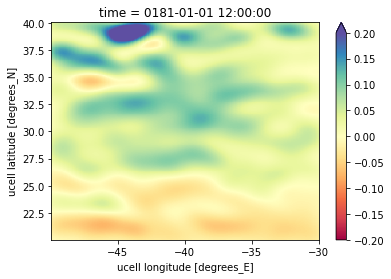

In [44]:
plt.figure()
filtered_data2.plot(**plt_args)

Plot of dxt over the map

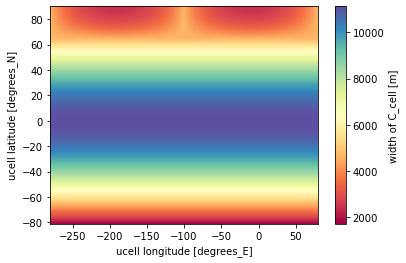

In [14]:
plt.figure()
grid_data['dxu'].plot(cmap='Spectral')#%%


Here we use a cartesian filter

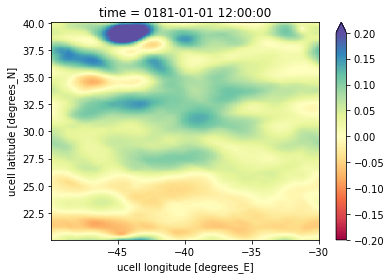

In [15]:
wet_mask = grid_data_save['wet'].interp(xt_ocean=data.xu_ocean,
                                        yt_ocean=data.yu_ocean)

cartesian_filter = filter.Filter(16, dx_min=1, n_steps=30,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars={'wet_mask': wet_mask},
                                 grid_type=GridType.CARTESIAN_WITH_LAND)
filtered_data3 = cartesian_filter.apply(data, dims=['yu_ocean', 'xu_ocean'])

filtered_data3.plot(**plt_args)